In [1]:
from __future__ import division, print_function
%matplotlib inline
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *
from keras.layers.merge import dot, add, concatenate

Using cuDNN version 5105 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:04:00.0)
Using Theano backend.


In [2]:
path = "data/ml-latest-small/"  # from https://grouplens.org/datasets/movielens/
#path = "data/ml-20m/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

batch_size=64
#batch_size=1

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [5]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict

In [9]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [12]:
# userId and movieId become ditionary elements with values ranging from 0 to max len 
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [13]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [14]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [15]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [16]:
n_factors = 50

In [17]:
np.random.seed = 42

Randomly split into training and validation.

In [18]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [19]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [20]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [21]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [22]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [23]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [24]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(input_dim=n_users, output_dim=n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(input_dim=n_movies, output_dim=n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

In [37]:
x = dot([u, m], axes=2)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [38]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80292 samples, validate on 19712 samples
Epoch 1/1
80292/80292 [==============================] - 2s - loss: 4.3174 - val_loss: 3.3280


In [39]:
model.optimizer.lr=0.01

In [40]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80292 samples, validate on 19712 samples
Epoch 1/3
80292/80292 [==============================] - 2s - loss: 2.7601 - val_loss: 2.7221
Epoch 2/3
80292/80292 [==============================] - 2s - loss: 2.3373 - val_loss: 2.5846
Epoch 3/3
80292/80292 [==============================] - 2s - loss: 2.2085 - val_loss: 2.5560


In [41]:
model.optimizer.lr=0.001

In [42]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80292 samples, validate on 19712 samples
Epoch 1/6
80292/80292 [==============================] - 2s - loss: 2.1578 - val_loss: 2.5482
Epoch 2/6
80292/80292 [==============================] - 2s - loss: 2.1298 - val_loss: 2.5491
Epoch 3/6
80292/80292 [==============================] - 2s - loss: 2.1063 - val_loss: 2.5560
Epoch 4/6
80292/80292 [==============================] - 2s - loss: 2.0855 - val_loss: 2.5582
Epoch 5/6
80292/80292 [==============================] - 2s - loss: 2.0624 - val_loss: 2.5702
Epoch 6/6
80292/80292 [==============================] - 2s - loss: 2.0423 - val_loss: 2.5764


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [43]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [44]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [45]:
def create_bias(inp, n_in):
    x = Embedding(input_dim=n_in, output_dim=1, input_length=1)(inp)
    return Flatten()(x)

In [46]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [47]:
x = dot([u, m], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, mb])
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [48]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80292 samples, validate on 19712 samples
Epoch 1/1
80292/80292 [==============================] - 2s - loss: 8.7433 - val_loss: 3.4836


In [49]:
model.optimizer.lr=0.01

In [50]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80292 samples, validate on 19712 samples
Epoch 1/6
80292/80292 [==============================] - 2s - loss: 2.5806 - val_loss: 2.3029
Epoch 2/6
80292/80292 [==============================] - 2s - loss: 1.9956 - val_loss: 2.1075
Epoch 3/6
80292/80292 [==============================] - 2s - loss: 1.8357 - val_loss: 2.0133
Epoch 4/6
80292/80292 [==============================] - 2s - loss: 1.7409 - val_loss: 1.9403
Epoch 5/6
80292/80292 [==============================] - 2s - loss: 1.6631 - val_loss: 1.8701
Epoch 6/6
80292/80292 [==============================] - 2s - loss: 1.5887 - val_loss: 1.8054


In [51]:
model.optimizer.lr=0.001

In [52]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80292 samples, validate on 19712 samples
Epoch 1/10
80292/80292 [==============================] - 2s - loss: 1.5190 - val_loss: 1.7389
Epoch 2/10
80292/80292 [==============================] - 2s - loss: 1.4496 - val_loss: 1.6736
Epoch 3/10
80292/80292 [==============================] - 2s - loss: 1.3808 - val_loss: 1.6142
Epoch 4/10
80292/80292 [==============================] - 2s - loss: 1.3144 - val_loss: 1.5591
Epoch 5/10
80292/80292 [==============================] - 2s - loss: 1.2491 - val_loss: 1.5088
Epoch 6/10
80292/80292 [==============================] - 2s - loss: 1.1878 - val_loss: 1.4578
Epoch 7/10
80292/80292 [==============================] - 2s - loss: 1.1288 - val_loss: 1.4163
Epoch 8/10
80292/80292 [==============================] - 2s - loss: 1.0732 - val_loss: 1.3694
Epoch 9/10
80292/80292 [==============================] - 2s - loss: 1.0205 - val_loss: 1.3295
Epoch 10/10
80292/80292 [==============================] - 2s - loss: 0.9703 - val_loss: 1.2908

In [53]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80292 samples, validate on 19712 samples
Epoch 1/5
80292/80292 [==============================] - 2s - loss: 0.9233 - val_loss: 1.2580
Epoch 2/5
80292/80292 [==============================] - 2s - loss: 0.8800 - val_loss: 1.2260
Epoch 3/5
80292/80292 [==============================] - 2s - loss: 0.8389 - val_loss: 1.1969
Epoch 4/5
80292/80292 [==============================] - 2s - loss: 0.8020 - val_loss: 1.1698
Epoch 5/5
80292/80292 [==============================] - 2s - loss: 0.7677 - val_loss: 1.1452


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [54]:
model.save_weights(model_path+'bias.h5')

In [55]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [56]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.9892]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [57]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [58]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names()[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [59]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.50823206, 'Battlefield Earth (2000)'),
 (-0.13802283, 'Speed 2: Cruise Control (1997)'),
 (-0.10757273, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.099033587, 'Little Nicky (2000)'),
 (-0.087039262, 'Super Mario Bros. (1993)'),
 (-0.049692307, 'Jaws 3-D (1983)'),
 (0.067072563, 'Godzilla (1998)'),
 (0.074751392, 'Police Academy 6: City Under Siege (1989)'),
 (0.075012401, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.077604346, 'Blade: Trinity (2004)'),
 (0.098121516, 'Batman & Robin (1997)'),
 (0.10278502, 'Haunting, The (1999)'),
 (0.11563323, 'Blair Witch Project, The (1999)'),
 (0.12438908, 'Howard the Duck (1986)'),
 (0.12522519, 'Lost in Space (1998)')]

In [60]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4108304, 'Tom Jones (1963)'),
 (1.3752841, 'Porco Rosso (Crimson Pig) (Kurenai no buta) (1992)'),
 (1.3736762, 'Letters from Iwo Jima (2006)'),
 (1.3715636, 'Avengers: Age of Ultron (2015)'),
 (1.3444295, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.3339735, 'Argo (2012)'),
 (1.328054, 'Shawshank Redemption, The (1994)'),
 (1.3223944,
  'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)'),
 (1.3075876, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.29387, 'Paprika (Papurika) (2006)'),
 (1.288847, 'Modern Times (1936)'),
 (1.2749821, 'General, The (1926)'),
 (1.2747028, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2723743,
  "Monty Python's And Now for Something Completely Different (1971)"),
 (1.2655969, 'The Revenant (2015)')]

We can now do the same thing for the embeddings.

In [61]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [63]:
fac0 = movie_pca[0]

In [64]:
movie_comp = [(f, movie_names()[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [65]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.011226126320379693, 'RoboCop 3 (1993)'),
 (0.0078716698259611688, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.0077262310347635081, 'Mission to Mars (2000)'),
 (0.0064721869975817269, 'Battlefield Earth (2000)'),
 (0.0062127231326777098, 'Barb Wire (1996)'),
 (0.0058832830348050065, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.0057819443702678492, 'X-Men Origins: Wolverine (2009)'),
 (0.0057817441730701391, 'Bio-Dome (1996)'),
 (0.005781389310885462, 'Howard the Duck (1986)'),
 (0.0054670725098811285, 'Lolita (1997)')]

In [66]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.052890492005052581, 'Wallace & Gromit: A Close Shave (1995)'),
 (-0.050841010663626743, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.049944742190885363, 'Amadeus (1984)'),
 (-0.049246174546123275,
  "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (-0.049152467014311127, 'Run Lola Run (Lola rennt) (1998)'),
 (-0.049128126059456503, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.049019741276832583, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.048763816592434478,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.048522566455089379, "Schindler's List (1993)"),
 (-0.048490031070226335, "Ferris Bueller's Day Off (1986)")]

In [67]:
fac1 = movie_pca[1]

In [68]:
movie_comp = [(f, movie_names()[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [69]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.089763794425230248, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.082481808992957262, 'Stargate (1994)'),
 (0.075202916964643554, 'Ace Ventura: Pet Detective (1994)'),
 (0.075096380784319031, 'Armageddon (1998)'),
 (0.073007693041213545, 'Rock, The (1996)'),
 (0.072833267497441609, 'Speed (1994)'),
 (0.071935710919232093, 'Titanic (1997)'),
 (0.070593224049008141, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (0.070216856704080149, 'Happy Gilmore (1996)'),
 (0.067770050911144394, 'Die Hard: With a Vengeance (1995)')]

In [70]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.065291630296936576, 'Brokeback Mountain (2005)'),
 (-0.062228361401071283, 'Annie Hall (1977)'),
 (-0.05711136955146863, 'Apocalypse Now (1979)'),
 (-0.055546273177881127, 'Vertigo (1958)'),
 (-0.053861524618477798, 'City Lights (1931)'),
 (-0.051540528501327648, 'Harold and Maude (1971)'),
 (-0.050212882067681805, 'Manhattan (1979)'),
 (-0.049323688257642717, 'Heavenly Creatures (1994)'),
 (-0.04888208810926576, '8 1/2 (8½) (1963)'),
 (-0.047568694007240744, 'Gosford Park (2001)')]

In [71]:
fac2 = movie_pca[2]

In [72]:
movie_comp = [(f, movie_names()[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [73]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.12771136594581653, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.12416130751199246,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.10774460999231848, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.097855138307821166, 'Matrix, The (1999)'),
 (0.096519093444194196, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.096028597633532206,
  'Lord of the Rings: The Return of the King, The (2003)'),
 (0.093372233415449646, 'Seven (a.k.a. Se7en) (1995)'),
 (0.092204737242516085, 'Fight Club (1999)'),
 (0.088830550133604566, 'Dark Knight, The (2008)'),
 (0.084454786769486812,
  'Star Wars: Episode V - The Empire Strikes Back (1980)')]

In [74]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.081268064072003571, 'Sabrina (1995)'),
 (-0.072882174081468354, 'Bend It Like Beckham (2002)'),
 (-0.069120924379602863, 'Pay It Forward (2000)'),
 (-0.066709931261842326, 'Legally Blonde (2001)'),
 (-0.065476502200492157, 'Postman, The (Postino, Il) (1994)'),
 (-0.065083000473015226, 'Sense and Sensibility (1995)'),
 (-0.062875264063149472, "Romy and Michele's High School Reunion (1997)"),
 (-0.059339590424728771, 'Beverly Hills Cop III (1994)'),
 (-0.05781742852876845, 'Sliding Doors (1998)'),
 (-0.056878951867276789, "Singin' in the Rain (1952)")]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [75]:
# The following would be for Python 2 only
# reload(sys)
# sys.setdefaultencoding('utf8')

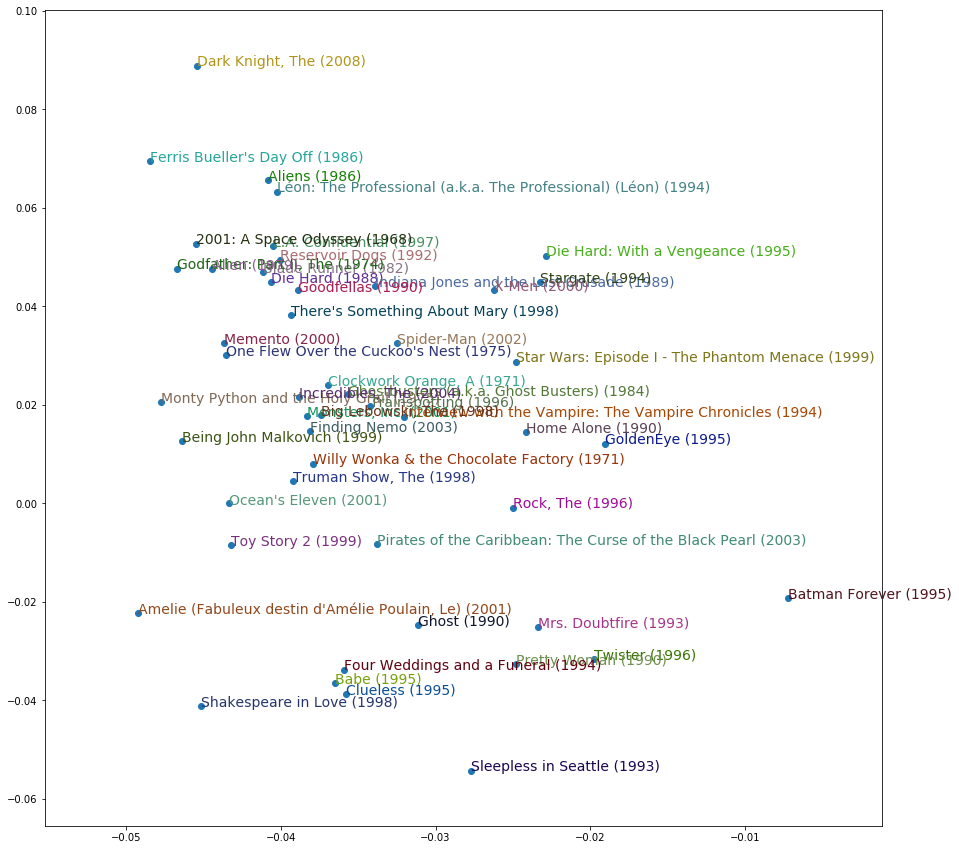

In [76]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names()[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [77]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [78]:
x = concatenate([u, m], axis=2)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [79]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80292 samples, validate on 19712 samples
Epoch 1/8
80292/80292 [==============================] - 3s - loss: 2.3960 - val_loss: 0.9385
Epoch 2/8
80292/80292 [==============================] - 2s - loss: 1.4498 - val_loss: 0.8699
Epoch 3/8
80292/80292 [==============================] - 2s - loss: 1.2115 - val_loss: 0.8653
Epoch 4/8
80292/80292 [==============================] - 2s - loss: 1.0385 - val_loss: 0.8551
Epoch 5/8
80292/80292 [==============================] - 2s - loss: 0.9135 - val_loss: 0.8363
Epoch 6/8
80292/80292 [==============================] - 2s - loss: 0.8502 - val_loss: 0.8304
Epoch 7/8
80292/80292 [==============================] - 2s - loss: 0.8197 - val_loss: 0.8268
Epoch 8/8
80292/80292 [==============================] - 2s - loss: 0.8115 - val_loss: 0.8313


This improves on our already impressive accuracy even further!